In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

from pyseis.wave_equations import acoustic_isotropic
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion

import sys
sys.path.append("../")
import plotting

MARMOUSI_PATH = '../Marmousi2_elastic.npz'

## Load and plot marmousi 

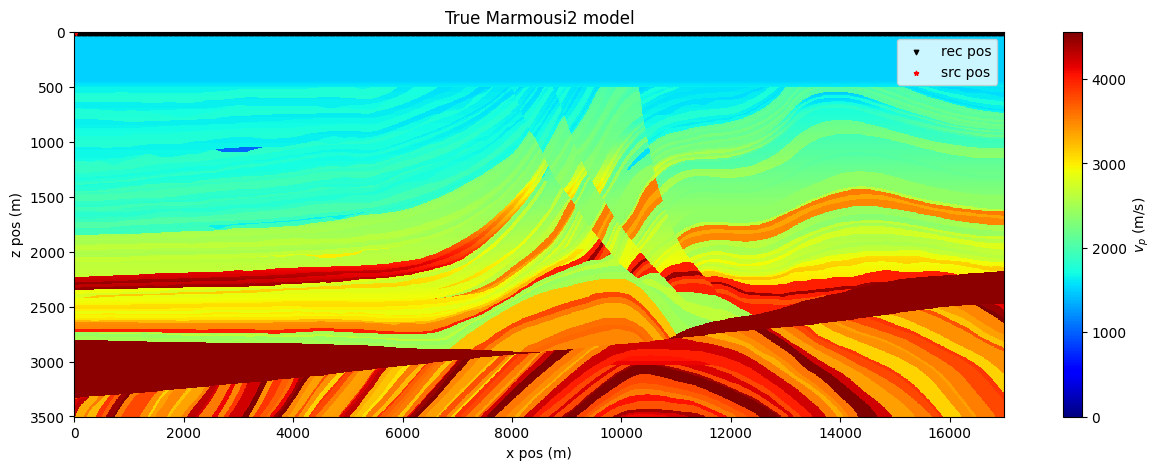

In [23]:
# load marmousi model
marm_npz = np.load(MARMOUSI_PATH)
true_model = marm_npz['model'][0] # window out p-wave velocity
model_sampling = tuple(marm_npz['model_sampling'])

# create source and receiver geometry
n_rec = true_model.shape[0]//2
x_rec = np.linspace(0.0,model_sampling[0]*true_model.shape[0],num=n_rec)
z_rec = 10.0 * np.ones_like(x_rec) 
recs = np.array([x_rec, z_rec]).T

x_src = np.array([10.0]) #np.array([model_sampling[0]*true_model.shape[0]//2])
z_src = np.array([10.0])
srcs = np.array([x_src, z_src]).T

plotting.plot_model(true_model,
           title='True Marmousi2 model', 
           cbar=True,
           src_locations=srcs,
           rec_locations=recs)

## Initialize acoustic wave equation solver

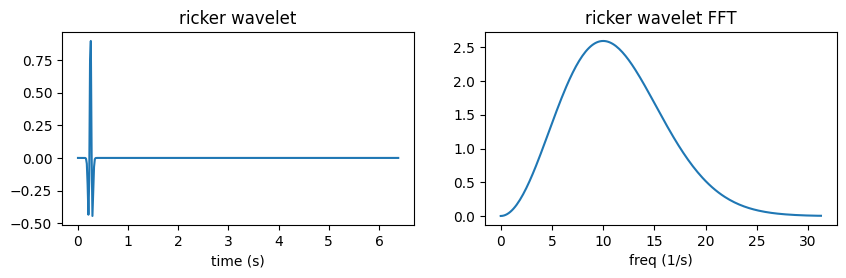

In [6]:
# make a Ricker wavelet
n_t = 626
d_t = 0.016
dom_freq = 10.0
delay = 0.25
ricker = Acoustic2D.AcousticIsotropicRicker2D(n_t, d_t, dom_freq, delay).arr

plotting.plot_wavelet(ricker[:400],d_t,title='ricker wavelet')

In [24]:
# make 2d acoustic wave equation solver
n_x_pad = n_z_pad = 80
acoustic_2d = acoustic_isotropic.AcousticIsotropic2D(
  model=true_model,
  model_sampling=model_sampling,
  model_padding=(n_x_pad, n_z_pad),
  wavelet=ricker,
  d_t=d_t,
  src_locations=srcs,
  rec_locations=recs,
  gpus=[0])

## Make observed data

In [25]:
%%time
data_obs, wavefield = acoustic_2d.forward(true_model, save_wavefield=1)

# plotting.plot_data(data_obs,
#           d_t,
#           src_locations=x_src,
#           rec_locations=x_rec)

CPU times: user 10.2 s, sys: 5.62 s, total: 15.9 s
Wall time: 12.9 s


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
import tempfile

# Create a 3D array (example: random data)
fps_base=63
skip=10
n_x, n_z = true_model.shape
fat = 4
data = np.copy(wavefield.getNdArray()[::skip,fat+n_x_pad:fat+n_x_pad + n_x,fat+n_z_pad:fat+n_z_pad + n_z])
x_axis = model_sampling[0] * np.arange(data.shape[-2])
z_axis = model_sampling[1] * np.arange(data.shape[-1])

# data /= 1.1*data.max()
# data*=true_model
# data+=true_model
# Create a temporary directory to store the image files
temp_dir = tempfile.mkdtemp()

pclip=99
clip=np.percentile(np.abs(data),pclip)

# Generate the 2D images for each slice along the first axis
image_files = []
for i in range(data.shape[0]):
    plt.figure(figsize=(10,5))
    
    # plt.pcolormesh(x_axis,z_axis,data[i, :, :].T, cmap='seismic', vmin=-clip, vmax=clip,shading='nearest')
    plt.title("%.2f sec" % (i*skip*d_t))
    # plt.gca().invert_yaxis()
    plt.imshow(true_model.T, cmap='gray', vmin=1500, vmax=4500)
    plt.imshow(data[i, :, :].T, alpha=0.4, cmap='seismic', vmin=-clip, vmax=clip)
    plt.axis('off')

    # Save the image as a temporary file
    image_file = os.path.join(temp_dir, f"slice_{i}.png")
    plt.savefig(image_file)
    plt.close()
    image_files.append(image_file)

# Create the GIF using the image files
gif_filename = "output.gif"
imageio.mimsave(gif_filename, [imageio.imread(f) for f in image_files], fps=fps_base//skip)

# Remove the temporary directory and files
for image_file in image_files:
    os.remove(image_file)
os.rmdir(temp_dir)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


In [ ]:
data.max()

In [ ]:
data.shape

Text(0.5, 1.0, '2.11 sec')

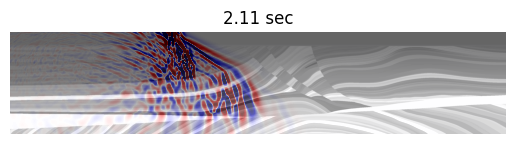

In [50]:
plt.imshow(true_model.T, cmap='gray', vmin=1500, vmax=4500)
plt.imshow(data[5, :, :].T, alpha=0.4, cmap='seismic', vmin=-clip, vmax=clip)
plt.axis('off')
plt.title("%.2f sec" % (2.1111))